In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from functools import reduce
from matplotlib import rcParams

import runtime as rt
from theme import colors

# font parameters
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 12

## Monomer

In [2]:
# parameters
filepaths = {
    "wt": glob("benchmark_data/wt/monomers/*.fasta"),
    "baseline": glob("benchmark_data/wt/monomers/*.fasta"),
    "carbonara_maxseqid": glob("benchmark_data/carbonara/monomers/maxseqid/*.fasta"),
    "carbonara_minseqid": glob("benchmark_data/carbonara/monomers/minseqid/*.fasta"),
    "carbonara_minseqsim": glob("benchmark_data/carbonara/monomers/minseqsim/*.fasta"),
    "mpnn": glob("benchmark_data/mpnn/monomers/*.fasta"),
    "esm": glob("benchmark_data/esm/monomers/*.fasta"),
}
keys = ["baseline", "carbonara_maxseqid", "carbonara_minseqid", "carbonara_minseqsim", "mpnn", "esm"]
#keys = ["baseline", "carbonara_maxseqid", "mpnn", "esm"]

# read sequences
seqs = {}
for key in filepaths:
    seqs[key] = {}
    for fp in filepaths[key]:
        name = os.path.basename(fp).split('.')[0]
        _, seq = rt.read_fasta(fp)
        seqs[key][name] = seq 

# evaluate sequences
results = []
for key in keys:
    for sid in seqs[key]:
        if sid in seqs["wt"]:
            # get sequences pair
            seq_ref = seqs["wt"][sid]
            seq = seqs[key][sid]

            for i in range(len(seq)):
                if len(seq_ref[i]) == len(seq[i]):
                    # score scores
                    results.append({
                        "method": key,
                        "sid": sid,
                        #"cid": i,
                        "sequence_identity": rt.sequence_identity(seq_ref[0], seq[0]),
                        "sequence_similarity": rt.sequence_similarity(seq_ref[0], seq[0]),
                        "len": len(seq_ref[i]),
                    })

# pack results
dfm = pd.DataFrame(results).sort_values(["sid", "method"])
dfm = dfm.groupby("sid").filter(lambda x: len(x)==len(keys))
dfm.to_csv("results/monomers_sequence_analysis.csv", index=False)
dfm

,method,sid,sequence_identity,sequence_similarity,len
34,baseline,1ABO_A,1.000000,1.000000,58
176,carbonara_maxseqid,1ABO_A,0.637931,0.827586,58
318,carbonara_minseqid,1ABO_A,0.275862,0.724138,58
460,carbonara_minseqsim,1ABO_A,0.275862,0.551724,58
718,esm,1ABO_A,0.551724,0.741379,58
...,...,...,...,...,...
182,carbonara_maxseqid,6R3C_A,0.289308,0.484277,159
324,carbonara_minseqid,6R3C_A,0.081761,0.383648,159
466,carbonara_minseqsim,6R3C_A,0.081761,0.132075,159
724,esm,6R3C_A,0.314465,0.477987,159


In [3]:
def set_violinplot_color(vp, color):
    vp['cmedians'].set_edgecolor(color)
    for pc in vp['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)

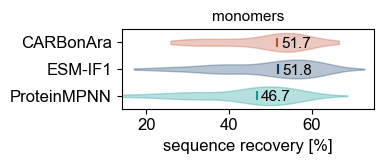

In [4]:
# parameters
keys = ["carbonara_maxseqid", "esm", "mpnn"][::-1]
labels = ['CARBonAra', 'ESM-IF1', 'ProteinMPNN'][::-1]

v = 1e2*np.stack([dfm[dfm['method'] == key]['sequence_identity'].values for key in keys], axis=1)
mv = np.median(v, axis=0)

plt.figure(figsize=(4, 1.8))
vp0 = plt.violinplot(v[:,0], [0], vert=False, showextrema=False, showmedians=True, widths=0.7)
vp1 = plt.violinplot(v[:,1], [1], vert=False, showextrema=False, showmedians=True, widths=0.7)
vp2 = plt.violinplot(v[:,2], [2], vert=False, showextrema=False, showmedians=True, widths=0.7)
set_violinplot_color(vp0, colors[2])
set_violinplot_color(vp1, colors[1])
set_violinplot_color(vp2, colors[0])
plt.text(mv[0]+1.0, 0, '{:.1f}'.format(mv[0]), va='center_baseline', fontsize=11)
plt.text(mv[1]+1.0, 1, '{:.1f}'.format(mv[1]), va='center_baseline', fontsize=11)
plt.text(mv[2]+1.0, 2, '{:.1f}'.format(mv[2]), va='center_baseline', fontsize=11)
plt.yticks(np.arange(3), labels)
plt.xlim(14, 75)
plt.xlabel('sequence recovery [%]')
plt.title("monomers", fontsize=11)
plt.tight_layout()
plt.savefig("graphs/methods_comparison_monomers.svg")
plt.show()

In [7]:
keys = ['carbonara_maxseqid', 'mpnn', 'esm']

results_comparison = {}
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        ckey = f"{keys[i]}:{keys[j]}"
        results_comparison[ckey] = []
        for sid in seqs[keys[i]]:
            seqi = seqs[keys[i]][sid][0]
            seqj = seqs[keys[j]][sid][0]
            if len(seqi) == len(seqj):
                results_comparison[ckey].append([
                    rt.sequence_identity(seqi, seqj),
                    rt.sequence_similarity(seqi, seqj),
                ])

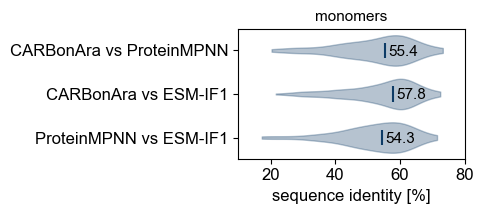

In [26]:
labels_map = {
    "carbonara_maxseqid": 'CARBonAra',
    "esm": 'ESM-IF1',
    "mpnn": 'ProteinMPNN',
}

ckeys = list(results_comparison)[::-1]
labels = [" vs ".join([labels_map[mn] for mn in ckey.split(':')]) for ckey in ckeys]

# sequence identity
X_l = [1e2*np.array(results_comparison[ckey])[:,0] for ckey in ckeys]
mv_l = [np.median(x) for x in X_l]

# plot
plt.figure(figsize=(5, 2.3))
vp0 = plt.violinplot(X_l[0], [0], vert=False, showextrema=False, showmedians=True, widths=0.7)
vp1 = plt.violinplot(X_l[1], [1], vert=False, showextrema=False, showmedians=True, widths=0.7)
vp2 = plt.violinplot(X_l[2], [2], vert=False, showextrema=False, showmedians=True, widths=0.7)
set_violinplot_color(vp0, colors[1])
set_violinplot_color(vp1, colors[1])
set_violinplot_color(vp2, colors[1])
plt.text(mv_l[0]+1.0, 0, '{:.1f}'.format(mv_l[0]), va='center_baseline', fontsize=11)
plt.text(mv_l[1]+1.0, 1, '{:.1f}'.format(mv_l[1]), va='center_baseline', fontsize=11)
plt.text(mv_l[2]+1.0, 2, '{:.1f}'.format(mv_l[2]), va='center_baseline', fontsize=11)
plt.yticks(np.arange(3), labels)
plt.xlim(10, 80)
plt.xlabel('sequence identity [%]')
plt.title("monomers", fontsize=11)
plt.tight_layout()
plt.savefig("graphs/methods_overlap_identity_monomers.svg")
plt.savefig("graphs/methods_overlap_identity_monomers.png", dpi=300)
plt.show()

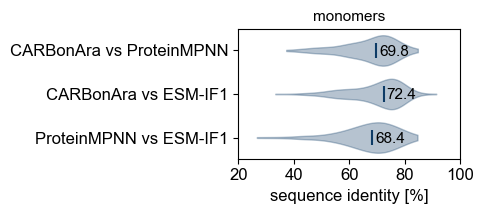

In [27]:
# sequence similarity
X_l = [1e2*np.array(results_comparison[ckey])[:,1] for ckey in ckeys]
mv_l = [np.median(x) for x in X_l]

# plot
plt.figure(figsize=(5, 2.3))
vp0 = plt.violinplot(X_l[0], [0], vert=False, showextrema=False, showmedians=True, widths=0.7)
vp1 = plt.violinplot(X_l[1], [1], vert=False, showextrema=False, showmedians=True, widths=0.7)
vp2 = plt.violinplot(X_l[2], [2], vert=False, showextrema=False, showmedians=True, widths=0.7)
set_violinplot_color(vp0, colors[1])
set_violinplot_color(vp1, colors[1])
set_violinplot_color(vp2, colors[1])
plt.text(mv_l[0]+1.0, 0, '{:.1f}'.format(mv_l[0]), va='center_baseline', fontsize=11)
plt.text(mv_l[1]+1.0, 1, '{:.1f}'.format(mv_l[1]), va='center_baseline', fontsize=11)
plt.text(mv_l[2]+1.0, 2, '{:.1f}'.format(mv_l[2]), va='center_baseline', fontsize=11)
plt.yticks(np.arange(3), labels)
plt.xlim(20, 100)
plt.xlabel('sequence identity [%]')
plt.title("monomers", fontsize=11)
plt.tight_layout()
plt.savefig("graphs/methods_overlap_similarity_monomers.svg")
plt.savefig("graphs/methods_overlap_similarity_monomers.png", dpi=300)
plt.show()

## Dimer

In [5]:
# parameters
filepaths = {
    "wt": glob("benchmark_data/wt/dimers/*.fasta"),
    "carbonara_maxseqid": glob("benchmark_data/carbonara/dimers/maxseqid/*.fasta"),
    "carbonara_minseqid": glob("benchmark_data/carbonara/dimers/minseqid/*.fasta"),
    "carbonara_minseqsim": glob("benchmark_data/carbonara/dimers/minseqsim/*.fasta"),
    "mpnn": glob("benchmark_data/mpnn/dimers/*.fasta"),
    "esm": glob("benchmark_data/esm/dimers/*.fasta"),
}
keys = ["carbonara_maxseqid", "carbonara_minseqid", "carbonara_minseqsim", "mpnn", "esm"]
#keys = ["carbonara_maxseqid", "mpnn", "esm"]

# read sequences
seqs = {}
for key in filepaths:
    seqs[key] = {}
    for fp in filepaths[key]:
        name = os.path.basename(fp).split('.')[0]
        _, seq = rt.read_fasta(fp)
        seqs[key][name] = seq 

# evaluate sequences
pdbid_done = []
results = []
for key in keys:
    for sid in seqs[key]:
        pdbid = sid.split('_')[0]
        if pdbid in seqs["wt"]:
            # get sequences pair
            seq_ref = sorted(seqs["wt"][pdbid], key=lambda x: len(x))
            seq = sorted(seqs[key][sid], key=lambda x: len(x))
            
            # check sizes
            if np.all([len(seq_ref[i]) == len(seq[i]) for i in range(len(seq_ref))]):
                # locate designed chain
                iord = np.argmin([rt.sequence_identity(seq_ref[i], seq[i]) for i in range(len(seq_ref))])
            
                # score scores
                results.append({
                    "method": key,
                    "sid": sid,
                    "sequence_identity": rt.sequence_identity(seq_ref[iord], seq[iord]),
                    "sequence_similarity": rt.sequence_similarity(seq_ref[iord], seq[iord]),
                    "len": len(seq_ref[iord]),
                })
            else:
                print(key, [len(s) for s in seq_ref], [len(s) for s in seq])

# pack results
dfd = pd.DataFrame(results).sort_values(["sid", "method"])
dfd = dfd.groupby("sid").filter(lambda x: len(x)==len(keys))
dfd.to_csv("results/dimers_sequence_analysis.csv", index=False)
dfd

mpnn [318, 319] [318, 325]
mpnn [322, 323] [323, 329]
mpnn [318, 319] [319, 324]
mpnn [325, 327] [327, 332]
mpnn [325, 328] [328, 332]
mpnn [322, 323] [322, 330]
mpnn [314, 315] [315, 319]
mpnn [312, 314] [314, 325]
mpnn [323, 323] [323, 330]
mpnn [293, 305] [293, 306]
mpnn [293, 305] [294, 305]
mpnn [322, 322] [322, 329]
mpnn [323, 323] [323, 330]
mpnn [315, 315] [315, 320]
mpnn [315, 315] [315, 320]
mpnn [325, 327] [325, 335]
mpnn [314, 315] [314, 320]
mpnn [322, 322] [322, 329]
mpnn [312, 314] [312, 327]
mpnn [325, 328] [325, 336]


,method,sid,sequence_identity,sequence_similarity,len
13,carbonara_maxseqid,1DAN_T,0.640000,0.733333,75
75,carbonara_minseqid,1DAN_T,0.146667,0.533333,75
137,carbonara_minseqsim,1DAN_T,0.146667,0.373333,75
241,esm,1DAN_T,0.586667,0.693333,75
196,mpnn,1DAN_T,0.600000,0.680000,75
...,...,...,...,...,...
49,carbonara_maxseqid,6PNW_B,0.467742,0.693548,62
111,carbonara_minseqid,6PNW_B,0.258065,0.548387,62
173,carbonara_minseqsim,6PNW_B,0.258065,0.274194,62
277,esm,6PNW_B,0.483871,0.645161,62


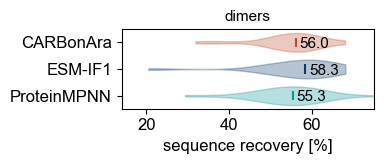

In [6]:
# parameters
keys = ["carbonara_maxseqid", "esm", "mpnn"][::-1]
labels = ['CARBonAra', 'ESM-IF1', 'ProteinMPNN'][::-1]

# get data
v = 1e2*np.stack([dfd[dfd['method'] == key]['sequence_identity'].values for key in keys], axis=1)
mv = np.median(v, axis=0)

# plot
plt.figure(figsize=(4, 1.8))
vp0 = plt.violinplot(v[:,0], [0], vert=False, showextrema=False, showmedians=True, widths=0.7)
vp1 = plt.violinplot(v[:,1], [1], vert=False, showextrema=False, showmedians=True, widths=0.7)
vp2 = plt.violinplot(v[:,2], [2], vert=False, showextrema=False, showmedians=True, widths=0.7)
set_violinplot_color(vp0, colors[2])
set_violinplot_color(vp1, colors[1])
set_violinplot_color(vp2, colors[0])
plt.text(mv[0]+1.0, 0, '{:.1f}'.format(mv[0]), va='center_baseline', fontsize=11)
plt.text(mv[1]+1.0, 1, '{:.1f}'.format(mv[1]), va='center_baseline', fontsize=11)
plt.text(mv[2]+1.0, 2, '{:.1f}'.format(mv[2]), va='center_baseline', fontsize=11)
plt.yticks(np.arange(3), labels)
plt.xlim(14, 75)
plt.xlabel('sequence recovery [%]')
plt.title("dimers", fontsize=11)
plt.tight_layout()
plt.savefig("graphs/methods_comparison_dimers.svg")
plt.show()